<a href="https://colab.research.google.com/github/BrunoEMendes/Google_colab_NN/blob/master/MutiLayerGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU PREDICT TEMPERATURE AND RAINFALL

Data extracted from "https://climateknowledgeportal.worldbank.org/download-data"

Dataset structure : [year month Rainfall Temperature]

In [82]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

## Data Manipulation

### Load Data

In [83]:
from pandas import read_csv

file_url = "https://raw.githubusercontent.com/BrunoEMendes/Google_colab_NN/master/weather_predict/input/temp-rain.csv"
dataset = read_csv(file_url)
print(dataset[:12])


     Year  Month   Rainfall  Temperature
0    1901      1   95.41630      7.87119
1    1901      2   94.85550      6.38664
2    1901      3  167.21800      9.50226
3    1901      4   56.53060     13.22100
4    1901      5   41.43890     15.69000
5    1901      6   11.08040     19.98460
6    1901      7    5.27905     21.56480
7    1901      8    4.28003     22.13090
8    1901      9   99.67530     18.29120
9    1901     10   79.87950     13.71970
10   1901     11   71.79130      9.62800
11   1901     12  100.22600      6.79127


Knowing the difference between each index is a month, then we know that index 0 is 1st month of 1st year (1901) and index 1 is 2nd month of 1st year and so on

In [84]:
df = dataset.dropna()
df = df[['Temperature', 'Rainfall']]
print(df[:12])

    Temperature   Rainfall
0       7.87119   95.41630
1       6.38664   94.85550
2       9.50226  167.21800
3      13.22100   56.53060
4      15.69000   41.43890
5      19.98460   11.08040
6      21.56480    5.27905
7      22.13090    4.28003
8      18.29120   99.67530
9      13.71970   79.87950
10      9.62800   71.79130
11      6.79127  100.22600


In [85]:
print(df.describe())

       Temperature     Rainfall
count  1392.000000  1392.000000
mean     14.725823    68.009047
std       5.036300    58.965178
min       5.460670     0.254600
25%      10.217500    22.757625
50%      14.118400    52.278700
75%      19.695425    96.766000
max      24.551800   331.242000


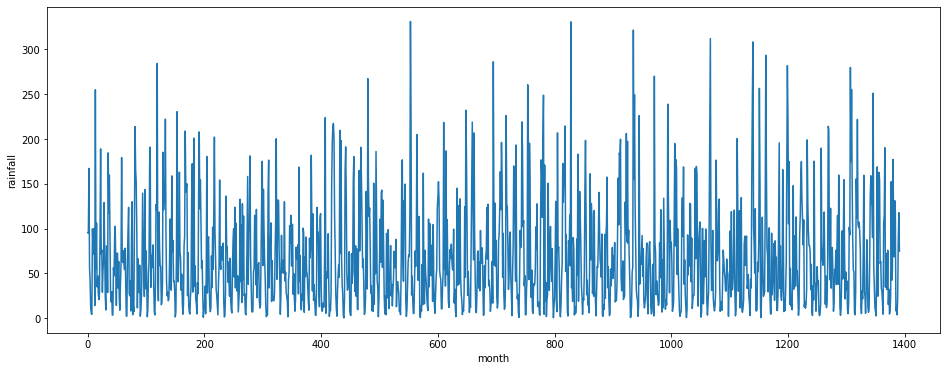

In [86]:
import matplotlib.pyplot as plt
plt.figure(1, figsize =(16, 6))
plt.plot(df.Rainfall)
plt.xlabel('month')
plt.ylabel('rainfall')
plt.show()

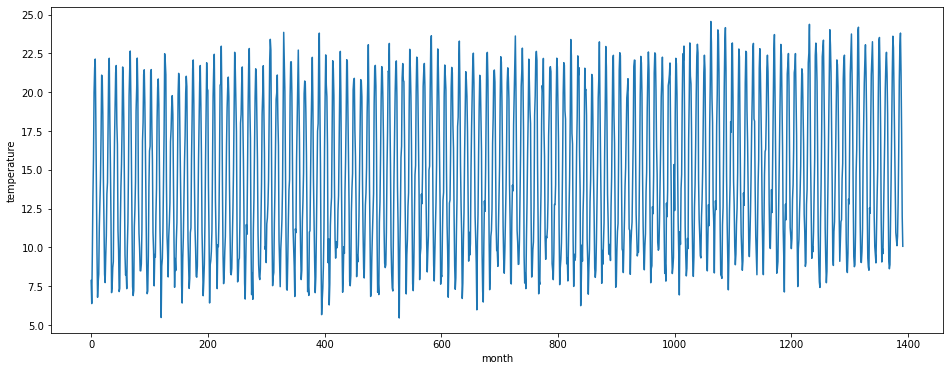

In [87]:
plt.figure(1, figsize =(16, 6))
plt.plot(df.Temperature)
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

### Data Normalization

In [88]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range = (0, 1))
X = min_max_scaler.fit_transform(df.values)
print(X[:12])
print('---')
print('X data shape: ', X.shape)

[[0.12626387 0.28750853]
 [0.04850263 0.2858142 ]
 [0.21169988 0.50444035]
 [0.40648877 0.1700246 ]
 [0.53581585 0.1244286 ]
 [0.76076848 0.03270759]
 [0.84353991 0.01518019]
 [0.87319242 0.01216188]
 [0.6720676  0.30037609]
 [0.43261085 0.24056777]
 [0.21828619 0.21613119]
 [0.06969729 0.3020399 ]]
---
X data shape:  (1392, 2)


### Train/Test Split

We are trying to forecast the temperatures and rainfall for years to come, therefore our target(y) will correspond to the temperatures

In [89]:
y = X[:, :]
print(y)
print('---')
print(y.shape)

[[0.12626387 0.28750853]
 [0.04850263 0.2858142 ]
 [0.21169988 0.50444035]
 ...
 [0.62124295 0.25537377]
 [0.34291475 0.35512349]
 [0.24175782 0.22511642]]
---
(1392, 2)


Split data Test data = 20%

In [90]:
from sklearn.model_selection import train_test_split
test_size_var = 0.20
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = test_size_var, random_state = 42)
print('X train shape: ', Xtrain.shape)
print('Y train shape: ', ytrain.shape)
print('X test shape: ', Xtest.shape)
print('Y test shape: ', ytest.shape)

X train shape:  (1113, 2)
Y train shape:  (1113, 2)
X test shape:  (279, 2)
Y test shape:  (279, 2)


### Build Train/Test Time Series

To predict $t + 1$ into the future we will check $n_{time\_steps}$ in the past

In [91]:
# one step = 1 month 
time_steps = 60

def get_data_time_steps(X, y, time_steps = 3):

    Xres = []
    yres = []

    for i in range(time_steps, len(X)):
        Xres.append(X[i - time_steps: i, : X.shape[1]])
        yres.append(y[i])

    return np.array(Xres), np.array(yres)

X_train, y_train = get_data_time_steps(Xtrain, ytrain, time_steps)
X_test, y_test = get_data_time_steps(Xtest, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)


X train shape:  (1053, 60, 2)
Y train shape:  (1053, 2)
X test shape:  (219, 60, 2)
Y test shape:  (219, 2)


## Gated Recurrent Unit Neural Network Model

In [92]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.recurrent import GRU

model = Sequential()
model.add(GRU(256, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 256)               199680    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 200,194
Trainable params: 200,194
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train, y_train, batch_size=64, epochs=500)

### Ploting last 100 predictions

Evaluate train dada
33/33 [==============================] - 1s 33ms/step - loss: 6.2222e-06
6.2222238739195745e-06
---
Evaluate test dada
7/7 [==============================] - 0s 33ms/step - loss: 0.0974
0.09742044657468796
---
7/7 [==============================] - 0s 32ms/step


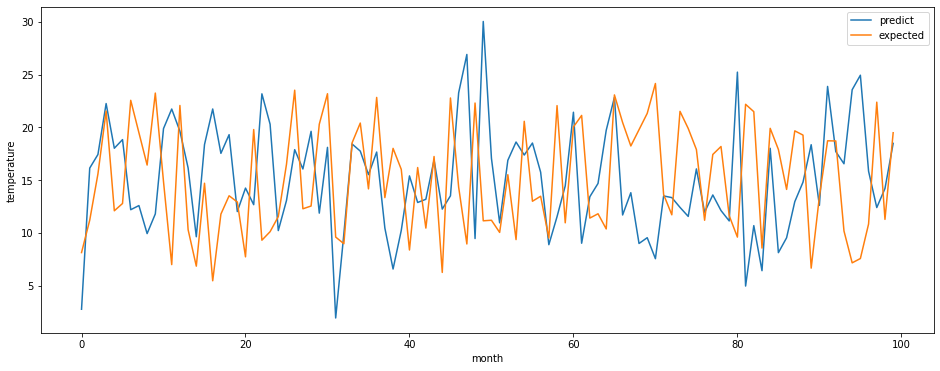

In [94]:
print('Evaluate train dada')
print(model.evaluate(X_train, y_train))
print('---')
print('Evaluate test dada')
print(model.evaluate(X_test, y_test))
print('---')

def inverse_scaling(y_inverted):
  return min_max_scaler.inverse_transform(y_inverted)


y_predict = model.predict(X_test, verbose = 1)
y_predict_inverted = inverse_scaling(y_predict)[len(y_predict) - 100:]
y_test_inverted = inverse_scaling(y_test)[len(y_predict) - 100:]

plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, len(y_predict_inverted)), y_predict_inverted[:, 0], label = 'predict')
expec_plot,  = plt.plot(range(0, len(y_test_inverted)), y_test_inverted[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

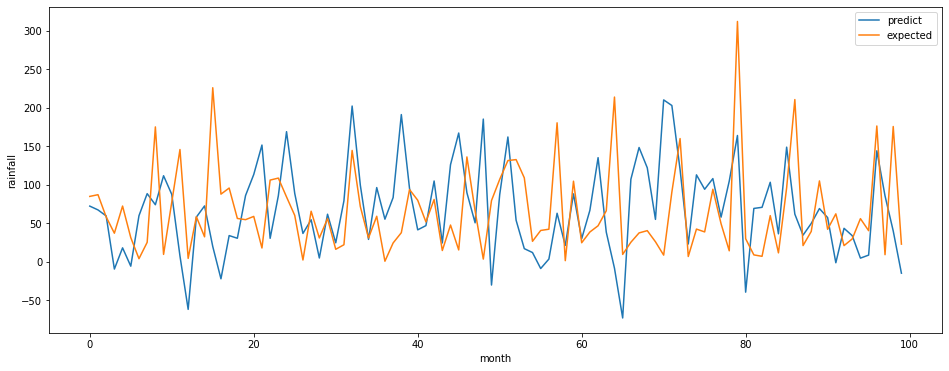

In [95]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, len(y_predict_inverted)), y_predict_inverted[:, 1], label = 'predict')
expec_plot,  = plt.plot(range(0, len(y_test_inverted)), y_test_inverted[:, 1], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('rainfall')
plt.show()

### Predict Future

We will try now using the data from $Xtrain$ to predict the $ytest$ step by step.

So if we use the last $time\_steps$ values of $Xtrain$, we should be abble to predict the first value of $ytest$ 

In [96]:
X_future = []
for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
  X_future.append(Xtrain[i - time_steps: i, :])

X_future = np.array(X_future)
y_future = model.predict(X_future)
y_future_inversed = inverse_scaling(y_future)
print('Next month temperature and rainfall: ', y_future_inversed[:5])
print('Expected :', inverse_scaling(y_test)[0, :])

Next month temperature and rainfall:  [[ 10.010929 152.03166 ]]
Expected : [19.0026   7.36895]


### Predict multiple steps into the future

For each month that we predict, we will train the Neural Network with the values obtained and compare to the test data, which should be in fact named valid data for this.

First we will be creating a deep clone of our GRU model


In [97]:
#not used for now, but it will be later I think :)

from keras.models import clone_model

# creating a model copy so we dont destroy our model
model_copy = clone_model(model)

# because the cloen doesnt copy the weights, optimizer and loss function we have to set them up
model_copy.compile(loss='mse', optimizer='adam')
model_copy.set_weights(model.get_weights())

# assert if copy is the equal to the model
assert model_copy.evaluate(X_train, y_train) == model.evaluate(X_train, y_train)

print('---')
print(model_copy.summary())
print('---')

33/33 [==============================] - 1s 33ms/step - loss: 6.2222e-06
---
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 256)               199680    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 200,194
Trainable params: 200,194
Non-trainable params: 0
_________________________________________________________________
None
---


Each Step we predict the next values using the values that we generated on the previous step


In [171]:
n_months_predict =  48

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = Xtrain

# loop n_months times
for i in range(n_months_predict):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = model_copy.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')

  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

#print(inverse_scaling(X_future_train_data[len(Xtrain):]))
#print(inverse_scaling(ytest[:n_months_predict]))

print('mse:', mean_squared_error(ytest[:n_months_predict], X_future_train_data[len(Xtrain):]))

mse: 0.07496031525674429


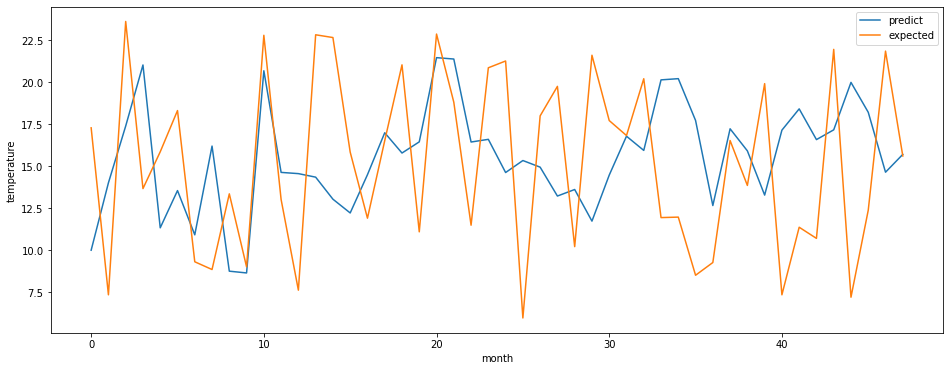

In [172]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(X_future_train_data[len(Xtrain):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(ytest[:n_months_predict])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()


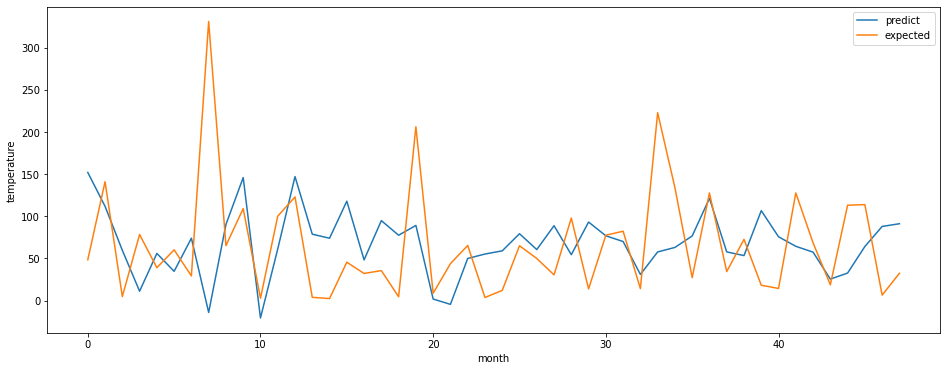

In [99]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(X_future_train_data[len(Xtrain):])[:, 1], label = 'predict')
expec_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(ytest[:n_months_predict])[:, 1], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

## Multi Layer GRU

In [143]:
# NN with 2 GRU layers and a Dropout Layer(MAYBE)

model_ml_gru = Sequential()
model_ml_gru.add(GRU(256, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model_ml_gru.add(GRU(256, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
model_ml_gru.add(Dense(2, activation='linear'))

model_ml_gru.compile(loss='mean_squared_error', optimizer='adam')

print(model_ml_gru.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_52 (GRU)                 (None, 60, 256)           199680    
_________________________________________________________________
gru_53 (GRU)                 (None, 256)               394752    
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 514       
Total params: 594,946
Trainable params: 594,946
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

model_ml_gru.fit(X_train, y_train, batch_size=64, epochs=500)

### Ploting last 100 results

In [174]:
print('Evaluate train dada')
print(model_ml_gru.evaluate(X_train, y_train))
print('---')
print('Evaluate test dada')
print(model_ml_gru.evaluate(X_test, y_test))
print('---')

def inverse_scaling(y_inverted):
  return min_max_scaler.inverse_transform(y_inverted)


y_predict = model_ml_gru.predict(X_test, verbose = 1)
y_predict_inverted = inverse_scaling(y_predict)[len(y_predict) - 100:]
y_test_inverted = inverse_scaling(y_test)[len(y_predict) - 100:]



Evaluate train dada
33/33 [==============================] - 3s 81ms/step - loss: 3.8184e-04
0.00038184202276170254
---
Evaluate test dada
7/7 [==============================] - 1s 86ms/step - loss: 0.0770
0.07704092562198639
---
7/7 [==============================] - 1s 79ms/step


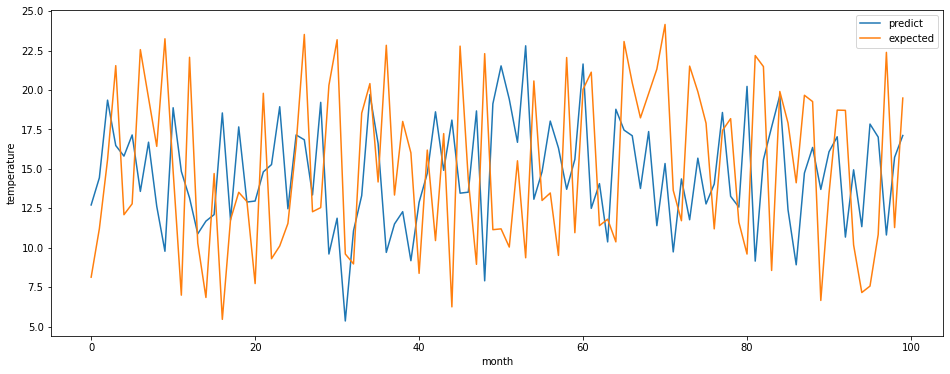

In [175]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, len(y_predict_inverted)), y_predict_inverted[:, 0], label = 'predict')
expec_plot,  = plt.plot(range(0, len(y_test_inverted)), y_test_inverted[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

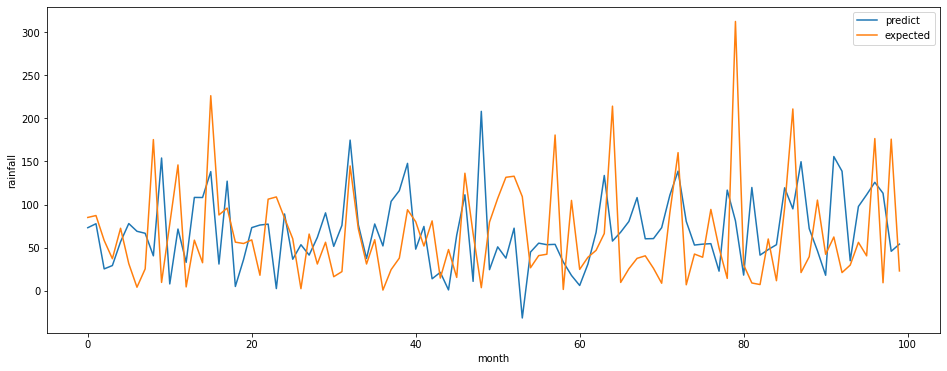

In [151]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, len(y_predict_inverted)), y_predict_inverted[:, 1], label = 'predict')
expec_plot,  = plt.plot(range(0, len(y_test_inverted)), y_test_inverted[:, 1], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('rainfall')
plt.show()

### Predict Future

In [199]:
X_future = []
for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
  X_future.append(Xtrain[i - time_steps: i, :])

X_future = np.array(X_future)
y_future = model_ml_gru.predict(X_future)
y_future_inversed = inverse_scaling(y_future)
print('Next month temperature and rainfall: ', y_future_inversed[:5])
print('Expected :', inverse_scaling(y_test)[0, :])

Next month temperature and rainfall:  [[16.255646 83.58361 ]]
Expected : [19.0026   7.36895]


In [200]:
n_months_predict =  48

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = Xtrain

# loop n_months times
for i in range(n_months_predict):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = model_ml_gru.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')

  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

#print(inverse_scaling(X_future_train_data[len(Xtrain):]))
#print(inverse_scaling(ytest[:n_months_predict]))
print('mse:', mean_squared_error(ytest[:n_months_predict], X_future_train_data[len(Xtrain):]))

mse: 0.05761383765707544


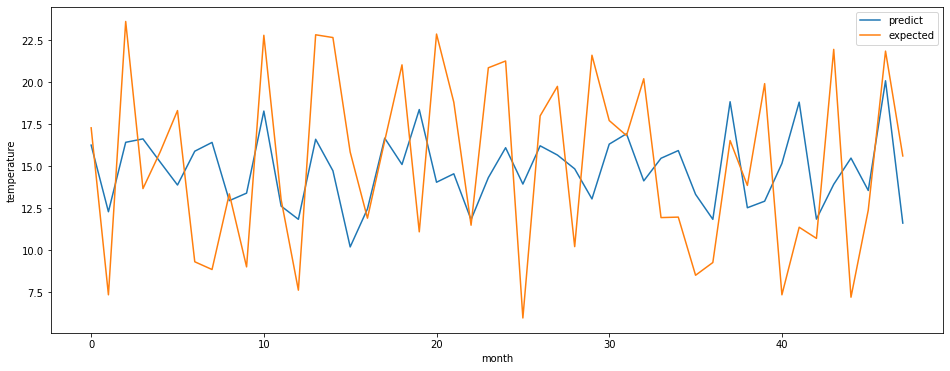

In [166]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(X_future_train_data[len(Xtrain):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(ytest[:n_months_predict])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

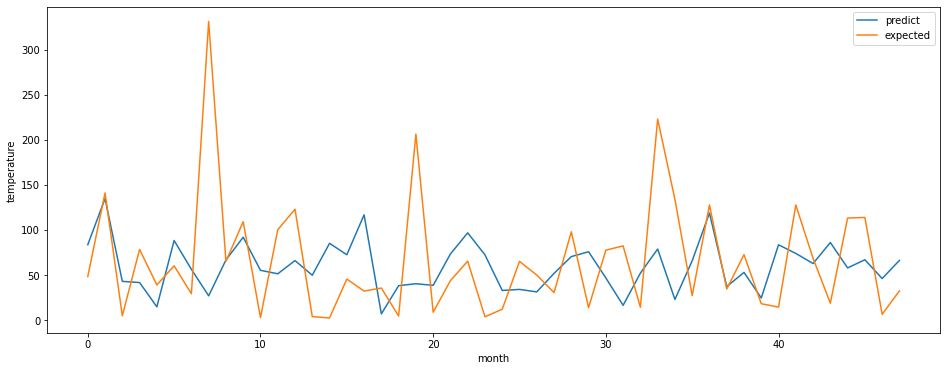

In [153]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(X_future_train_data[len(Xtrain):])[:, 1], label = 'predict')
expec_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(ytest[:n_months_predict])[:, 1], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

## Multi Layer GRU with Dropout Layer

In [177]:
#idk where is the best place to use dropout layers but in this https://www.kaggle.com/charel/learn-by-example-rnn-lstm-gru-time-series they use 2 so we will see

model_mld_gru = Sequential()
model_mld_gru.add(GRU(256, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model_mld_gru.add(Dropout(0.2))
model_mld_gru.add(GRU(256, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
model_mld_gru.add(Dropout(0.2))
model_mld_gru.add(Dense(2))

model_mld_gru.compile(loss='mean_squared_error', optimizer='adam')

print(model_mld_gru.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_56 (GRU)                 (None, 60, 256)           199680    
_________________________________________________________________
dropout_19 (Dropout)         (None, 60, 256)           0         
_________________________________________________________________
gru_57 (GRU)                 (None, 256)               394752    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 514       
Total params: 594,946
Trainable params: 594,946
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_mld_gru.fit(X_train, y_train, batch_size=64, epochs=500)

### Ploting last 100 results

In [202]:
print('Evaluate train dada')
print(model_mld_gru.evaluate(X_train, y_train))
print('---')
print('Evaluate test dada')
print(model_mld_gru.evaluate(X_test, y_test))
print('---')

def inverse_scaling(y_inverted):
  return min_max_scaler.inverse_transform(y_inverted)


y_predict = model_mld_gru.predict(X_test, verbose = 1)
y_predict_inverted = inverse_scaling(y_predict)[len(y_predict) - 100:]
y_test_inverted = inverse_scaling(y_test)[len(y_predict) - 100:]


Evaluate train dada
33/33 [==============================] - 3s 78ms/step - loss: 4.3283e-04
0.00043283402919769287
---
Evaluate test dada
7/7 [==============================] - 1s 74ms/step - loss: 0.0620
0.06199633702635765
---
7/7 [==============================] - 1s 77ms/step


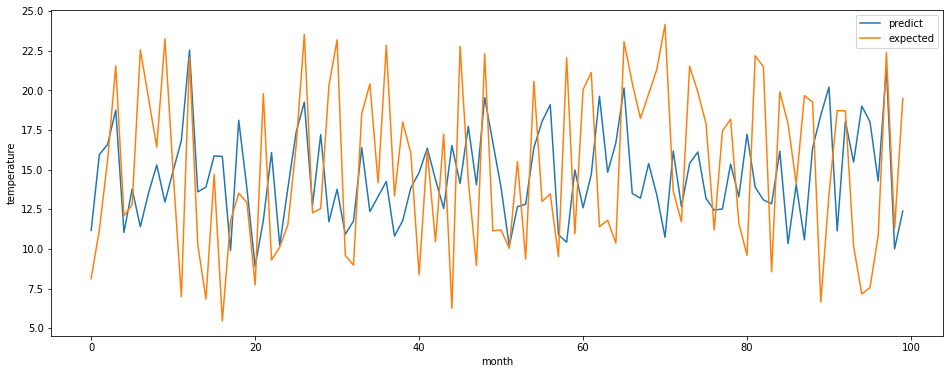

In [201]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, len(y_predict_inverted)), y_predict_inverted[:, 0], label = 'predict')
expec_plot,  = plt.plot(range(0, len(y_test_inverted)), y_test_inverted[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

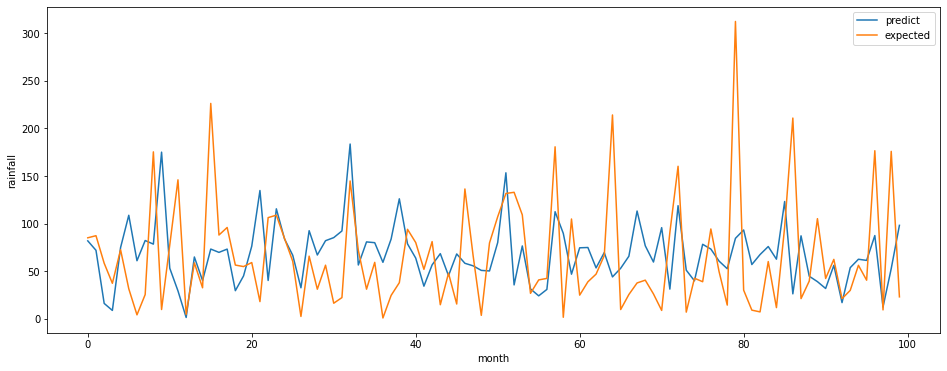

In [195]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, len(y_predict_inverted)), y_predict_inverted[:, 1], label = 'predict')
expec_plot,  = plt.plot(range(0, len(y_test_inverted)), y_test_inverted[:, 1], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('rainfall')
plt.show()

### Predict Future


In [198]:
X_future = []
for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
  X_future.append(Xtrain[i - time_steps: i, :])

X_future = np.array(X_future)
y_future = model_mld_gru.predict(X_future)
y_future_inversed = inverse_scaling(y_future)
print('Next month temperature and rainfall: ', y_future_inversed[:5])
print('Expected :', inverse_scaling(y_test)[0, :])

Next month temperature and rainfall:  [[16.124308 63.881653]]
Expected : [19.0026   7.36895]


In [190]:
n_months_predict =  48

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = Xtrain

# loop n_months times
for i in range(n_months_predict):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = model_mld_gru.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')

  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

#print(inverse_scaling(X_future_train_data[len(Xtrain):]))
#print(inverse_scaling(ytest[:n_months_predict]))
print('mse:', mean_squared_error(ytest[:n_months_predict], X_future_train_data[len(Xtrain):]))

mse: 0.0794623444987885


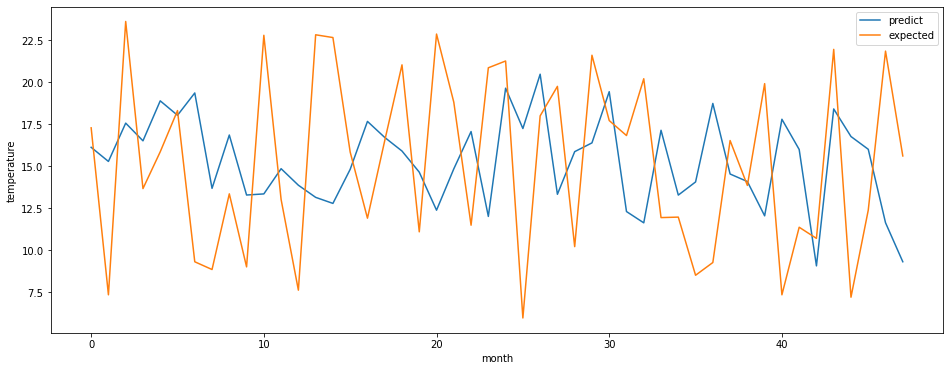

In [191]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(X_future_train_data[len(Xtrain):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(ytest[:n_months_predict])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

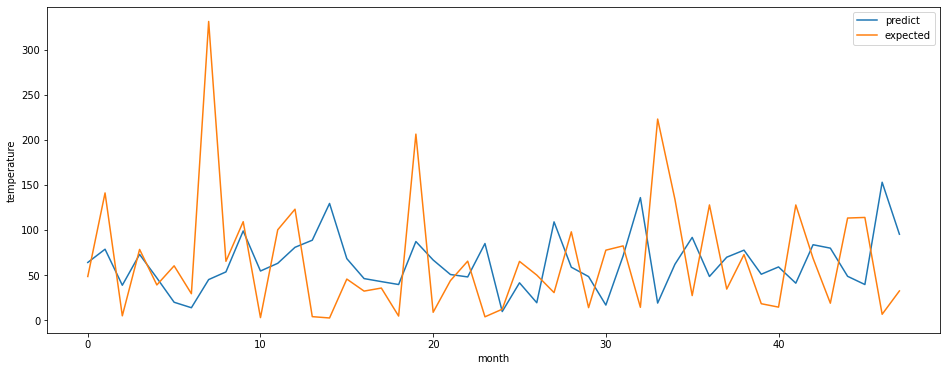

In [192]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(X_future_train_data[len(Xtrain):])[:, 1], label = 'predict')
expec_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(ytest[:n_months_predict])[:, 1], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()